In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')

grid_df = pd.read_csv('./data/grid_data.csv')
grid_df = grid_df.fillna(0)

import numpy as np
from sklearn.model_selection import train_test_split

class GridTimeSeriesDataset:
    def __init__(self, dataframe, scale=False):

        self.dataframe = dataframe
        self.days = np.sort(self.dataframe['day'].unique())  # Unique sorted days
        self.train, self.test = train_test_split(self.days, test_size=0.1, random_state=42)

        self.scale = scale
        if self.scale: self.load_samples()

        # Compute min and max values for normalization
        self.min = dataframe.min()
        self.max = dataframe.max()

    def __len__(self):
        return len(self.days)

    def __getitem__(self, index):
        if index >= len(self.days):
            raise IndexError("Index out of range")

        day = self.days[index]
        day_data = self.dataframe[self.dataframe['day'] == day].copy()
        
        if self.scale:
            day_data['solar (MW)'] = self.min_max_scale(day_data['solar (MW)'], ts_type='solar')
            day_data['wind (MW)'] = self.min_max_scale(day_data['wind (MW)'], ts_type='wind')
            day_data['load (MW)'] = self.min_max_scale(day_data['load (MW)'], ts_type='load')
            day_data['price (EUR/MWh)'] = self.min_max_scale(day_data['price (EUR/MWh)'], ts_type='price')
            day_data['emission factor (kg CO2/MWh)'] = self.min_max_scale(day_data['emission factor (kg CO2/MWh)'], ts_type='co2')
            # day_data['solar (MW)'] = self.scale_feature(day_data['solar (MW)'], ts_type='solar')
            # day_data['solar (MW)'] = self.remove_bias(day_data['solar (MW)'])
            # day_data['wind (MW)'] =  self.scale_feature(day_data['wind (MW)'], ts_type='wind')
            # day_data['load (MW)'] =  self.scale_feature(day_data['load (MW)'], ts_type='load')


        return {
            'time': np.arange(len(day_data)),  # Time indices
            'solar': day_data['solar (MW)'].to_numpy(dtype=np.float32),
            'wind': day_data['wind (MW)'].to_numpy(dtype=np.float32),
            'load': day_data['load (MW)'].to_numpy(dtype=np.float32),
            'solar_forecast': day_data['solar_forcast (MW)'].to_numpy(dtype=np.float32),
            'wind_forecast': day_data['wind_forecast (MW)'].to_numpy(dtype=np.float32),
            'load_forecast': day_data['load_forecast (MW)'].to_numpy(dtype=np.float32),
            'price': day_data['price (EUR/MWh)'].to_numpy(dtype=np.float32),
            'emission_factor': day_data['emission factor (kg CO2/MWh)'].to_numpy(dtype=np.float32),
        }
    
    def load_samples(self):
        # Load sample time series (to scale to the sample data)
        sample_solar = np.repeat(np.load('./data/sample/pv.npy'), 4)
        sample_wind = np.repeat(np.load('./data/sample/wt.npy'), 4)
        sample_load = np.repeat(np.load('./data/sample/load.npy'), 4)
        sample_price = np.repeat(np.load('./data/sample/price.npy'), 4)
        sample_co2 = np.repeat(np.load('./data/sample/co2.npy'), 4)/1000

        # Compute the mean and std of the sample time series
        self.mean_solar = np.mean(sample_solar)
        self.std_solar = np.std(sample_solar)
        self.min_solar = np.min(sample_solar)
        self.max_solar = np.max(sample_solar)

        self.mean_wind = np.mean(sample_wind)
        self.std_wind = np.std(sample_wind)
        self.min_wind = np.min(sample_wind)
        self.max_wind = np.max(sample_wind)

        self.mean_load = np.mean(sample_load)
        self.std_load = np.std(sample_load)
        self.min_load = np.min(sample_load)
        self.max_load = np.max(sample_load)

        self.mean_price = np.mean(sample_price)
        self.std_price = np.std(sample_price)
        self.min_price = np.min(sample_price)
        self.max_price = np.max(sample_price)

        self.mean_co2 = np.mean(sample_co2)
        self.std_co2 = np.std(sample_co2)
        self.min_co2 = np.min(sample_co2)
        self.max_co2 = np.max(sample_co2)

    # Apply Z-score standardization and rescale to sample's mean and std
    def scale_feature(self, data, ts_type):
        if ts_type == 'solar': mean_sample, std_sample = self.mean_solar, self.std_solar
        elif ts_type == 'wind': mean_sample, std_sample = self.mean_wind, self.std_wind
        elif ts_type == 'load': mean_sample, std_sample = self.mean_load, self.std_load

        feature_mean = np.mean(data)
        feature_std = np.std(data)
        return (data - feature_mean) / feature_std * std_sample + mean_sample

    def remove_bias(self, data):
        return data - np.min(data)
    
    def min_max_scale(self, data, ts_type):
        if ts_type == 'solar': min_sample, max_sample = self.min_solar, self.max_solar
        elif ts_type == 'wind': min_sample, max_sample = self.min_wind, self.max_wind
        elif ts_type == 'load': min_sample, max_sample = self.min_load, self.max_load
        elif ts_type == 'price': min_sample, max_sample = self.min_price, self.max_price
        elif ts_type == 'co2': min_sample, max_sample = self.min_co2, self.max_co2
        min_data = np.min(data)
        max_data = np.max(data)
        return (data - min_data) / (max_data - min_data) * (max_sample - min_sample) + min_sample


# Example Usage:
dataset = GridTimeSeriesDataset(grid_df, scale=True)
sample = dataset[42]


Text(0, 0.5, 'State of Charge (%)')

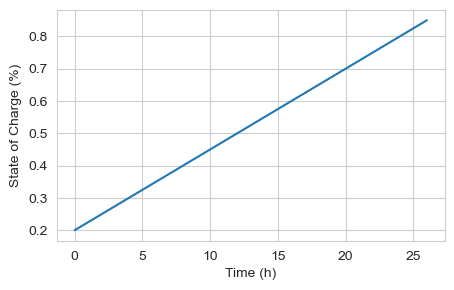

In [2]:
class storage:
    def __init__(self, SOC, dt):
        # Parameters
        self.eta_charge = 1
        self.eta_discharge = 1
        self.Capacity = 40 # kWh
        # Constraints
        self.Pbatt_max = 4 # kW
        self.SOC_min = 0.2
        self.SOC_max = 0.85
        # Variables
        self.SOC = np.clip(SOC, self.SOC_min, self.SOC_max)
        self.dt = dt

    def update(self, Pbatt):
        self.SOC += (self.eta_charge/self.Capacity)*np.maximum(0, Pbatt)*self.dt +\
                    (1/self.eta_discharge/self.Capacity)*min(0, Pbatt)*self.dt
        return self.SOC


test_battery = storage(SOC=0.2, dt=1)
SOC_PLOT = [test_battery.SOC]

while test_battery.SOC<test_battery.SOC_max:
    Pbatt = 1
    test_battery.update(Pbatt)

    SOC_PLOT.append(test_battery.SOC)

plt.figure(figsize=(5,3))
plt.plot(SOC_PLOT)
plt.grid(True)
plt.xlabel('Time (h)')
plt.ylabel('State of Charge (%)')

In [3]:
#  Define the dictionary
DG_coeffs = {
    "MT": {
        "Pmin": 6,  # kW
        "Pmax": 30, # kW
        "b" : 4.37, # €/kWh
        "c": 85.06, # €/h
        "ef": 724.6/1000,# kg/kWh
        "Type": "Microturbine"
    },
    "FC": {
        "Pmin": 3,   # kW
        "Pmax": 30,  # kW
        "b": 2.84,   # €/kWh
        "c": 255.18, # €/h
        "ef": 489.4/1000, # kg/kWh
        "Type": "FC"
    },
    "WT": {
        "Pmin": 0,  # kW
        "Pmax": 15, # kW
        "b": 10.63, # €/kWh
        "c": 0,     # €/h
        "ef": 0,    # kg/MWh
        "Type": "Wind Turbine"
    },
    "PV1": {
        "Pmin": 0,  # kW
        "Pmax": 3,  # kW
        "b": 54.84, # €/kWh
        "c": 0,     # €/h
        "ef": 0,    # kg/MWh
        "Type": "Photovoltaic 1"
    },
    "PV2": {
        "Pmin": 0 , # kW
        "Pmax": 10, # kW
        "b": 54.84, # €/kWh
        "c": 0,     # €/h
        "ef": 0,    # kg/MWh
        "Type": "Photovoltaic 2"
    }
}

# Print the dictionary
pprint(DG_coeffs)


{'FC': {'Pmax': 30,
        'Pmin': 3,
        'Type': 'FC',
        'b': 2.84,
        'c': 255.18,
        'ef': 0.4894},
 'MT': {'Pmax': 30,
        'Pmin': 6,
        'Type': 'Microturbine',
        'b': 4.37,
        'c': 85.06,
        'ef': 0.7246},
 'PV1': {'Pmax': 3,
         'Pmin': 0,
         'Type': 'Photovoltaic 1',
         'b': 54.84,
         'c': 0,
         'ef': 0},
 'PV2': {'Pmax': 10,
         'Pmin': 0,
         'Type': 'Photovoltaic 2',
         'b': 54.84,
         'c': 0,
         'ef': 0},
 'WT': {'Pmax': 15,
        'Pmin': 0,
        'Type': 'Wind Turbine',
        'b': 10.63,
        'c': 0,
        'ef': 0}}


In [4]:
# Function to add Gaussian noise with varying intensity and proportional to power
def add_uncertainty(time_series, start_time, base_noise_std):
    time_steps = np.linspace(0, len(time_series), len(time_series))
    noisy_series = time_series.copy()
    start_index = np.searchsorted(time_steps, start_time)+1
    total_horizon = len(time_series) - start_index

    # Define the Gaussian uncertainty function
    for i in range(start_index, len(time_series)):
        time_distance = (i - start_index) / total_horizon  # Normalize distance to [0, 1]
        # Gaussian function for uncertainty, centered at the midpoint of the horizon
        uncertainty_scale = np.exp(-0.5 * ((time_distance - 1) ** 2) / (0.7 ** 2))  # Narrow Gaussian
        noise_scale = base_noise_std * uncertainty_scale  # Scale noise by the Gaussian function
        noise = np.random.normal(0, noise_scale) * noisy_series[i]
        noisy_series[i] += noise

    noisy_series[start_index:] = np.clip(noisy_series[start_index:], 0, None)  # Ensure no negative power
    return noisy_series

In [5]:
import gymnasium as gym
import numpy as np

class MicroGridTemporalEnv(gym.Env):
    def __init__(self, grid_df, DG_coeffs):
        super(MicroGridTemporalEnv, self).__init__()
        
        self.day = 0  # Start at the first day
        self.t = 0
        self.dt = 0.25  # Time step (hours)
        self.MAX_STEP = 24 * (1 / self.dt)  # Number of time steps in a day

        self.timeseries = GridTimeSeriesDataset(grid_df, scale=True)
        self.DG_coeffs = DG_coeffs
        self.battery = storage(SOC=0.5, dt=self.dt)

        self.PGmax = 200
        self.PBmax = self.battery.Pbatt_max
        self.bigM = 10

        self.Bi = [v["b"] for v in DG_coeffs.values()]
        self.Ci = [v["c"] for v in DG_coeffs.values()]
        self.EFi = [v["ef"] for v in DG_coeffs.values()]

        # Get min/max values from the dataset for normalization
        self.data_min = grid_df.min()
        self.data_max = grid_df.max()

        # Define action space: [-1,1] mapped to actual power ranges
        self.action_space = gym.spaces.Box(low=-1, high=1, shape=(3,), dtype=np.float32)
        # Define observation space: Normalize relevant state variables to [-1,1]
        self.observation_space = gym.spaces.Box(low=-1, high=1, shape=(7,), dtype=np.float32)

        self.memory = {'power': [], 'storage': []}


    def normalize(self, value, min_val, max_val):
        return 2 * (value - min_val) / (max_val - min_val) - 1


    def denormalize(self, value, min_val, max_val):
        return (value + 1) / 2 * (max_val - min_val) + min_val


    def step(self, action):
        # Get the time-series data for the current day
        day_data = self.timeseries[self.day]

        Pbatt = self.denormalize(action[0], -self.PBmax, self.PBmax)
        Pgi = [
            self.denormalize(action[1], list(self.DG_coeffs.values())[0]['Pmin'], list(self.DG_coeffs.values())[0]['Pmax']),
            self.denormalize(action[2], list(self.DG_coeffs.values())[1]['Pmin'], list(self.DG_coeffs.values())[1]['Pmax'])
        ]
        
        # Get time-series values
        DEMAND = day_data['load'][self.t]
        BG = day_data['price'][self.t]
        EFG = day_data['emission_factor'][self.t]
        PV = day_data['solar'][self.t]
        WIND = day_data['wind'][self.t]

        self.battery.update(Pbatt)

        Pgi_all = np.hstack([Pgi, [WIND, PV, PV]])
        PG = -(Pgi_all.sum() - Pbatt - DEMAND)
        
        Power_Cost = np.sum(self.Bi[:2] * Pgi_all[:2] + self.Ci[:2]) + (BG * PG)
        Env_Cost = np.sum(self.EFi[:2] * Pgi_all[:2]) + (EFG * PG)

        PG_constraint = np.maximum(0, PG - self.PGmax) + np.maximum(0, -self.PGmax - PG)

        Battery_constraint = np.clip(self.battery.SOC - self.battery.SOC_max, 0, np.inf) + \
                             np.clip(self.battery.SOC_min - self.battery.SOC, 0, np.inf)
        
        reward = -(Power_Cost + 1e-2 * Env_Cost) / 1e3 - self.bigM * (PG_constraint + 20 * Battery_constraint) + 2
        
        self.t += 1  # Move to the next time step
        done = self.t >= self.MAX_STEP  # End episode if all time steps are completed
        
        # Get next state
        next_DEMAND = day_data['load'][self.t] if not done else 0
        next_BG = day_data['price'][self.t] if not done else 0
        next_EFG = day_data['emission_factor'][self.t] if not done else 0
        next_PV = day_data['solar'][self.t] if not done else 0
        next_WIND = day_data['wind'][self.t] if not done else 0

        next_state = np.array([
            self.normalize(self.t, 0, self.MAX_STEP),
            self.normalize(next_DEMAND, self.timeseries.min_load, self.timeseries.max_load),
            self.normalize(next_WIND, self.timeseries.min_wind, self.timeseries.max_wind),
            self.normalize(next_PV, self.timeseries.min_solar, self.timeseries.max_solar),
            self.normalize(next_BG, self.timeseries.min_price, self.timeseries.max_price),
            self.normalize(next_EFG, self.timeseries.min_co2, self.timeseries.max_co2),
            self.normalize(self.battery.SOC, 0, 1)
        ])

        # Prepare the full observation (return the whole time-series data at each step)
        time_series = np.stack([
            self.normalize(add_uncertainty(day_data['load'],  self.t, base_noise_std=0.2), self.timeseries.min_load, self.timeseries.max_load),   # Demand
            self.normalize(add_uncertainty(day_data['wind'],  self.t, base_noise_std=0.2), self.timeseries.min_wind, self.timeseries.max_wind),   # Wind generation
            self.normalize(add_uncertainty(day_data['solar'], self.t, base_noise_std=0.2), self.timeseries.min_solar, self.timeseries.max_solar)  # PV generation
        ], axis=0).T

        next_observation =[time_series.astype(np.float32), next_state.astype(np.float32)]

        self.memory['power'].append(np.hstack([PG, Pbatt, Pgi, [WIND, PV, PV]]))
        self.memory['storage'].append(self.battery.SOC)
        
        info = {'NEXT DEMAND': DEMAND, 'Power_Cost': Power_Cost, 'Env_Cost': Env_Cost}
        return next_observation, reward, done, False, info

    def reset(self, test=False, day=None):
        self.t = 0
        self.battery = storage(SOC=0.5, dt=self.dt)
        if day is not None:
            self.day = day
        else:
            self.day = np.random.choice(self.timeseries.test) if test else np.random.choice(self.timeseries.train)

        day_data = self.timeseries[self.day]

        DEMAND = day_data['load'][self.t]
        BG = day_data['price'][self.t]
        EFG = day_data['emission_factor'][self.t]
        PV = day_data['solar'][self.t]
        WIND = day_data['wind'][self.t]

        state = np.array([
            self.normalize(self.t, 0, self.MAX_STEP),
            self.normalize(DEMAND, self.timeseries.min_load, self.timeseries.max_load),
            self.normalize(WIND, self.timeseries.min_wind, self.timeseries.max_wind),
            self.normalize(PV, self.timeseries.min_solar, self.timeseries.max_solar),
            self.normalize(BG, self.timeseries.min_price, self.timeseries.max_price),
            self.normalize(EFG, self.timeseries.min_co2, self.timeseries.max_co2),
            self.normalize(self.battery.SOC, 0, 1)
        ])


        # Prepare the full observation (return the whole time-series data at each step)
        time_series = np.stack([
            self.normalize(add_uncertainty(day_data['load'],  self.t, base_noise_std=0.2), self.timeseries.min_load, self.timeseries.max_load),   # Demand
            self.normalize(add_uncertainty(day_data['wind'],  self.t, base_noise_std=0.2), self.timeseries.min_wind, self.timeseries.max_wind),   # Wind generation
            self.normalize(add_uncertainty(day_data['solar'], self.t, base_noise_std=0.2), self.timeseries.min_solar, self.timeseries.max_solar)  # PV generation
        ], axis=0).T

        observation =[time_series.astype(np.float32), state.astype(np.float32)]

        self.memory['power'] = []
        self.memory['storage'] = []
        
        info = {'DEMAND': DEMAND, 'Power_Cost': 0, 'Env_Cost': 0}
        return observation, info

    def render(self):
        return 0

# Example Usage
env = MicroGridTemporalEnv(grid_df, DG_coeffs)
env.action_space, env.observation_space, env.reset(), env.step(np.ones(4,))

(Box(-1.0, 1.0, (3,), float32),
 Box(-1.0, 1.0, (7,), float32),
 ([array([[-1.66243315e-01,  1.00000000e+00, -1.00000000e+00],
          [-1.67179465e-01,  9.25714135e-01, -1.00000000e+00],
          [-4.23151016e-01,  9.48580027e-01, -1.00000000e+00],
          [-3.93728435e-01,  6.43424034e-01, -1.00000000e+00],
          [-6.73521042e-01,  2.62056470e-01, -1.00000000e+00],
          [-6.62061572e-01,  4.51822996e-01, -1.00000000e+00],
          [-6.26335859e-01,  4.69051838e-01, -1.00000000e+00],
          [-8.81778836e-01,  2.63015747e-01, -1.00000000e+00],
          [-7.21006870e-01,  3.10550809e-01, -1.00000000e+00],
          [-8.22729051e-01,  6.78776503e-02, -1.00000000e+00],
          [-9.51221228e-01,  2.94018388e-01, -1.00000000e+00],
          [-8.02574635e-01,  1.19664907e-01, -1.00000000e+00],
          [-9.35695231e-01,  2.98230767e-01, -1.00000000e+00],
          [-8.28070700e-01, -2.78388202e-01, -1.00000000e+00],
          [-9.70814347e-01,  1.50553584e-01, -1.000000

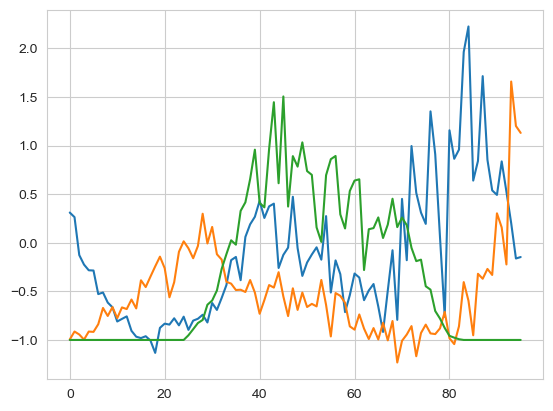

In [6]:
o,a = env.reset()
plt.plot(o[0])

# Models

### LSTM

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.distributions import Normal

device = "cuda" if torch.cuda.is_available() else "cpu"

# Gaussian Policy Network architecture
class LSTMGPNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dims, lstm_input_dim, lstm_hidden_dim):
        super().__init__()
        # LSTM branch for time series input
        self.lstm = nn.LSTM(lstm_input_dim, 1, batch_first=True)
        self.lstm_fc = nn.Linear(96, lstm_hidden_dim)

        # Fully connected branch for single-vector state input
        layers = []
        input_dim = state_dim + lstm_hidden_dim
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(input_dim, hidden_dim))
            layers.append(nn.ReLU())
            input_dim = hidden_dim
        self.fc_branch = nn.Sequential(*layers)

        # Final layers for mean and log standard deviation
        self.fc_mean = nn.Linear(input_dim, action_dim)
        self.fc_log_std = nn.Linear(input_dim, action_dim)

    def forward(self, time_series, state_vector):
        # Process time series with LSTM
        lstm_out, _ = self.lstm(time_series)
        lstm_out = lstm_out.reshape(-1, 96)  # Take the output of the last LSTM step
        lstm_out = self.lstm_fc(lstm_out)

        # Concatenate State abd LSTM outputs
        combined = torch.cat([state_vector, lstm_out], dim=-1)

        # Process single-vector state input
        fc_out = self.fc_branch(combined)

        # Compute mean and std of actions
        action_mean = self.fc_mean(fc_out)
        action_log_std = torch.clamp(self.fc_log_std(fc_out), min=-5, max=2)  # Adjusted range
        action_std = torch.exp(action_log_std)
        return action_mean, action_std

    def select_action(self, time_series, state_vector, deterministic=False):
        mean, std = self(time_series, state_vector)
        if deterministic: 
            action = torch.tanh(mean)  # Directly apply tanh for deterministic mode
            log_prob = torch.zeros_like(mean).sum(dim=-1, keepdim=True)
        else:
            normal_dist = Normal(mean, std)
            action_pre_tanh = normal_dist.rsample()  # Sample before applying tanh
            log_prob = normal_dist.log_prob(action_pre_tanh).sum(dim=-1, keepdim=True)
            
            # Apply tanh transformation correctly
            action = torch.tanh(action_pre_tanh)
            # Log probability correction for tanh squashing
            log_prob -= torch.log(1 - action.pow(2) + 1e-6).sum(dim=-1, keepdim=True)
        return action, log_prob

### Attention

In [8]:
import torch
import torch.nn as nn

class AttentionBlock(nn.Module):
    def __init__(self, input_dim):
        super(AttentionBlock, self).__init__()
        self.attention = nn.MultiheadAttention(embed_dim=input_dim, num_heads=input_dim, batch_first=True)
        self.fc = nn.Linear(input_dim, 1)
        self.tanh = nn.Tanh()

    def forward(self, x):
        attn_output, _ = self.attention(x, x, x)
        output = self.fc(attn_output)  
        output = self.tanh(output)
        return output
    
# Gaussian Policy Network architecture
class AttGPNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dims, attention_input_dim, attention_hidden_dim):
        super().__init__()
        # LSTM branch for time series input
        self.attention = AttentionBlock(input_dim=attention_input_dim)
        self.att_fc = nn.Linear(96, attention_hidden_dim)

        # Fully connected branch for single-vector state input
        layers = []
        input_dim = state_dim + attention_hidden_dim
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(input_dim, hidden_dim))
            layers.append(nn.ReLU())
            input_dim = hidden_dim
        self.fc_branch = nn.Sequential(*layers)

        # Final layers for mean and log standard deviation
        self.fc_mean = nn.Linear(input_dim, action_dim)
        self.fc_log_std = nn.Linear(input_dim, action_dim)

    def forward(self, time_series, state_vector):
        # Process time series with LSTM
        attention_out = self.attention(time_series)
        attention_out = attention_out.reshape(-1, 96)  # Take the output of the last LSTM step
        attention_out = self.att_fc(attention_out)

        # Concatenate State abd LSTM outputs
        combined = torch.cat([state_vector, attention_out], dim=-1)

        # Process single-vector state input
        fc_out = self.fc_branch(combined)

        # Compute mean and std of actions
        action_mean = self.fc_mean(fc_out)
        action_log_std = torch.clamp(self.fc_log_std(fc_out), min=-5, max=2)  # Adjusted range
        action_std = torch.exp(action_log_std)
        return action_mean, action_std

    def select_action(self, time_series, state_vector, deterministic=False):
        mean, std = self(time_series, state_vector)
        if deterministic: 
            action = torch.tanh(mean)  # Directly apply tanh for deterministic mode
            log_prob = torch.zeros_like(mean).sum(dim=-1, keepdim=True)
        else:
            normal_dist = Normal(mean, std)
            action_pre_tanh = normal_dist.rsample()  # Sample before applying tanh
            log_prob = normal_dist.log_prob(action_pre_tanh).sum(dim=-1, keepdim=True)
            
            # Apply tanh transformation correctly
            action = torch.tanh(action_pre_tanh)
            # Log probability correction for tanh squashing
            log_prob -= torch.log(1 - action.pow(2) + 1e-6).sum(dim=-1, keepdim=True)
        return action, log_prob
    


In [22]:
sequence_length = 24 
lstm_input_dim = 3   
lstm_hidden_dim = 8

attention_input_dim = 3   
attention_hidden_dim = 8

state_size = env.observation_space.shape[0]
action_size = env.action_space.shape[0]
action_max = env.action_space.high
hidden_dim = [256,256]
action_range=[-np.ones(3), np.ones(3)]

LSTMModel = LSTMGPNetwork(state_size, action_size, hidden_dim, lstm_input_dim, lstm_hidden_dim).to(device)
AttModel = AttGPNetwork(state_size, action_size, hidden_dim, attention_input_dim, attention_hidden_dim).to(device)

LSTMModel.load_state_dict(torch.load("Logs/LSTM_SAC_best_actor.pth", map_location=torch.device('cpu')))
AttModel.load_state_dict(torch.load("Logs/Attention_SAC_best_actor.pth", map_location=torch.device('cpu')))

<All keys matched successfully>

In [71]:
AttModel.attention.tanh

Tanh()

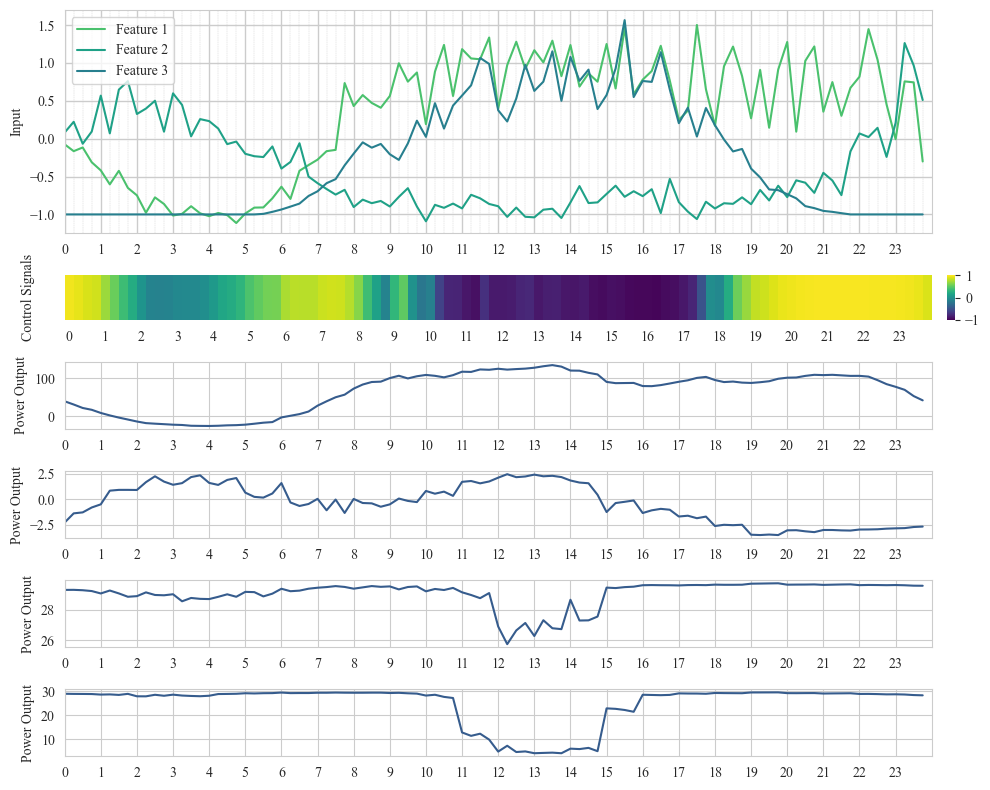

In [120]:
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from utils.asset import map_to_range, np_to_torch, torch_to_np

sns.set_style('whitegrid')
colors = sns.color_palette("viridis_r", 6)

plt.rcParams['font.family'] = 'Times New Roman'

# Hook storage
intermediate_output = None

# Hook function to store intermediate activations
def hook_fn(module, input, output):
    global intermediate_output
    intermediate_output = output[0].detach()  # Store hidden states

    
# Register hook on LSTM layer
AttModel.attention.tanh.register_forward_hook(hook_fn)
# LSTMModel.lstm.register_forward_hook(hook_fn)

state,_ = env.reset(test=True, day=200)
input_data_np = state[0]

grid_results = []
rewards = []
actions = []
done = False
while not done:
    grid_results = np.array(env.memory['power'])
    battery_results = np.array(env.memory['storage'])

    # convert to tensor
    state_t = [np_to_torch(state[0]).to(device), np_to_torch(state[1]).to(device)]
    # select action
    action_t, action_log_prob_t = AttModel.select_action(state_t[0], state_t[1], deterministic=True)
    # action_t, action_log_prob_t = LSTMModel.select_action(state_t[0], state_t[1], deterministic=True)
    # convert to numpy
    action = torch_to_np(action_t)
    action_log_prob = torch_to_np(action_log_prob_t)
    # map action to range
    mapped_action = map_to_range(action, action_range)
    # take action
    next_state, reward, done, _, info = env.step(mapped_action)
    state = next_state
    rewards.append(reward)

grid_results = np.array(env.memory['power'])
battery_results = np.array(env.memory['storage'])

# Convert input data for visualization
output = action

# Plotting
minor_hours = np.arange(0, 24, 0.25)
major_hours = np.arange(0, 24, 1)

fig, axs = plt.subplots(6, 2, figsize=(10, 8), gridspec_kw={'height_ratios': [1, 0.2, 0.3, 0.3, 0.3, 0.3], 'width_ratios': [5, 0.05]})
axs = axs.flatten()
axs[1].set_visible(False)  # Hide empty subplot
axs[5].set_visible(False)  # Hide empty subplot
axs[7].set_visible(False)  # Hide empty subplot
axs[9].set_visible(False)  # Hide empty subplot
axs[11].set_visible(False)  # Hide empty subplot

# 🟢 First subplot: 96x3 input as three separate line plots
for i in range(3):
    axs[0].plot(np.arange(96)/4, input_data_np[:, i], label=f'Feature {i+1}', color=colors[i+1])
axs[0].legend()
axs[0].set_ylabel("Input")
axs[0].set_xticks(minor_hours, minor=True)
axs[0].set_xticks(major_hours, minor=False)
axs[0].set_xlim(0, 24)
axs[0].grid(True, which='minor', linestyle='--', linewidth=0.3)
axs[0].grid(True, which='major', linestyle='-', linewidth=1)


# 🔵 Second subplot: Heatmap of 96x1 output
signal_df = pd.DataFrame([np.array(intermediate_output.reshape(-1))], columns=(np.arange(96)/4).astype(int))
signal_df.index = [" "]

sns.heatmap(signal_df, cmap="viridis", cbar=True, ax=axs[2], cbar_ax=axs[3], xticklabels=4, vmin=-1, vmax=1)
axs[2].set_ylabel("Control Signals")
# axs[2].set_xticks(np.arange(0,24.25,1))

for i in range(2, 6):
    axs[2*i].plot(np.arange(96)/4, grid_results[:,i-2], label="Grid", color=colors[4])
    # axs[2*i].set_xlabel("Time Step")
    axs[2*i].set_ylabel("Power Output")
    axs[2*i].set_xticks(minor_hours, minor=True)
    axs[2*i].set_xticks(major_hours, minor=False)
    axs[2*i].set_xlim(0, 24)


plt.tight_layout()
plt.show()

In [75]:
intermediate_output.shape

torch.Size([96, 1])

In [34]:
grid_results[:,0]

array([ 16.49815166,  16.95045203,  10.0480119 ,   3.77743596,
         3.47163415,   1.2782855 ,  -5.25341874,   2.39895332,
        -0.90928078,   1.44433236,  -2.64378655, -10.45665753,
        -4.48799145,  -5.13748509,  -9.63382792,  -8.93857723,
        -3.73095751,  -6.38879746,  -6.92437714,  -9.95163637,
        -5.91185492,  -2.32249784,  -6.22468901,  -3.13299078,
         4.43077457,   4.61808014,   8.73068476,  13.45596409,
        19.35408449,  21.51192749,  29.23038536,  34.16912293,
        37.6667304 ,  43.41755474,  50.52034265,  52.8547411 ,
        51.98246419,  50.19588637,  50.15783274,  50.12197244,
        52.91670883,  53.80362165,  50.06226325,  45.76305377,
        42.7277422 ,  40.77903527,  39.90661073,  38.95414913,
        37.83341336,  34.63567495,  32.98603386,  31.812204  ,
        25.06212735,  22.65351498,  22.49966574,  19.38848674,
        14.46352935,  11.40442204,   7.94197845,  12.32208496,
        19.4653182 ,  23.52240288,  39.08561313,  43.33

In [33]:
env.normalize(grid_results[:,0],-1,1)

array([ 16.49815166,  16.95045203,  10.0480119 ,   3.77743596,
         3.47163415,   1.2782855 ,  -5.25341874,   2.39895332,
        -0.90928078,   1.44433236,  -2.64378655, -10.45665753,
        -4.48799145,  -5.13748509,  -9.63382792,  -8.93857723,
        -3.73095751,  -6.38879746,  -6.92437714,  -9.95163637,
        -5.91185492,  -2.32249784,  -6.22468901,  -3.13299078,
         4.43077457,   4.61808014,   8.73068476,  13.45596409,
        19.35408449,  21.51192749,  29.23038536,  34.16912293,
        37.6667304 ,  43.41755474,  50.52034265,  52.8547411 ,
        51.98246419,  50.19588637,  50.15783274,  50.12197244,
        52.91670883,  53.80362165,  50.06226325,  45.76305377,
        42.7277422 ,  40.77903527,  39.90661073,  38.95414913,
        37.83341336,  34.63567495,  32.98603386,  31.812204  ,
        25.06212735,  22.65351498,  22.49966574,  19.38848674,
        14.46352935,  11.40442204,   7.94197845,  12.32208496,
        19.4653182 ,  23.52240288,  39.08561313,  43.33

In [16]:
output.shape

(3,)

In [14]:
np.array(intermediate_output[0,:,0])

array([-0.02829653, -0.13553095, -0.21128753, -0.43856195, -0.51876926,
       -0.45922014, -0.5978592 , -0.6386351 , -0.5101938 , -0.4299669 ,
       -0.33081734, -0.30535957, -0.05490985, -0.18115988, -0.04454815,
        0.00695763,  0.21254733,  0.40535688,  0.42052507,  0.2761617 ,
        0.36854506,  0.48101953,  0.67852336,  0.7291019 ,  0.50410485,
        0.2846966 ,  0.40380752,  0.44820717,  0.46354827,  0.70948   ,
        0.79280305,  0.8407646 ,  0.8549244 ,  0.8776596 ,  0.8758223 ,
        0.8811329 ,  0.88605654,  0.87259716,  0.82847744,  0.7955836 ,
        0.74851173,  0.64609486,  0.58894765,  0.32579583,  0.19112943,
        0.04012224, -0.12028736, -0.22034799, -0.18097208, -0.1565959 ,
       -0.45067614, -0.27179646, -0.17761469, -0.2599072 , -0.32461193,
       -0.3732847 , -0.277889  , -0.43210822, -0.25133142, -0.1616871 ,
        0.09883888,  0.2332115 ,  0.21459518,  0.44617793,  0.3702588 ,
        0.61303264,  0.7367681 ,  0.814213  ,  0.8527546 ,  0.75

In [30]:
intermediate_output.shape

torch.Size([1, 96, 1])